In [16]:
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import cv2
from cv2 import aruco
import matplotlib.pyplot as plt
import pandas as pd
import os
import polars as pl
import toml
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from support.pd_support import *

from datetime import datetime
from support.pd_support import *
from support.ar_calculations import *

from scipy.signal import savgol_filter
from scipy import integrate
from ahrs.filters import Madgwick
from scipy import stats
import toml

import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm import tqdm
import seaborn as sns

pio.renderers.default = "vscode"

In [17]:
_pth = toml.load('DATA_PATH.toml')['data_path']['directory']
_pth = os.path.dirname(_pth)
_parent_folder = "paper"
_calib_folder_name = "calibration_00"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)
_folder_name = 'angle_est_0'

_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

ar_lframe_pth = os.path.join(_webcam_calib_folder, "angle_rotmat.msgpack")
with open(ar_lframe_pth, "rb") as f:
    ar_lframe = mp.Unpacker(f, object_hook=mpn.decode)
    _ar_lframe_rot = next(ar_lframe)
    _ar_lframe_org = next(ar_lframe)

## Mocap data

In [18]:
m1 = get_rb_marker_name(1)
m2 = get_rb_marker_name(2)
m3 = get_rb_marker_name(3)
m4 = get_rb_marker_name(4)

In [19]:
def estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):

    marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, -marker_size / 2, 0],
                              [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(marker_points, c, mtx, distortion, True, flags= cv2.SOLVEPNP_ITERATIVE)
        
        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()
        
        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [20]:
_teensy_df = pl.read_csv(os.path.join(_base_pth,_folder_name,"imu01.csv"))
_teensy_df = _teensy_df.with_columns(pl.col("mz\r").str.replace("\r","").cast(pl.Float64).alias("mz"))
t_time = _teensy_df["rust_time"].to_numpy()
t_time = [datetime.fromtimestamp(t) for t in t_time]
# t_time = [datetime.strftime(t) for t in t_time]
teensy_df = pl.DataFrame({"time":t_time,"sync":_teensy_df["sync"]})

for idx, i in enumerate(teensy_df['sync']):
    if i == 1:
        break
teensy_start_time = teensy_df['time'][idx]

# Aruco parameters

ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
        size= [1,1],
        markerLength=markerLength,
        markerSeparation=markerSeperation,
        dictionary=ARUCO_DICT)

# timestamp
ts = []
ts_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")
ts_file = open(ts_pth, "rb")
ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
for ts_data in ts_unpacker:
    ts.append(ts_data)

In [21]:
_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

default_ids = [12, 88, 89]

data = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}

counter = 0

for _frame in tqdm(_video_data):

    shape = _frame.shape
    gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedpoints = detector.detectMarkers(_frame)
    # refine corners
    corners, ids, rejectedpoints,_ = detector.refineDetectedMarkers(image=_frame,board=board ,detectedCorners=corners, detectedIds=ids, rejectedCorners=rejectedpoints, cameraMatrix=_webcam_cam_mat, distCoeffs=_webcam_dist)
    rvec, tvec  = estimatePoseSingleMarkers(corners=corners, marker_size=markerLength, mtx=_webcam_cam_mat, distortion=_webcam_dist)

    if ids is None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(None)
        data["corners"].append(None)
        data["tvec"].append(None)
        data["rvec"].append(None)

    if ids is not None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(ids)
        data["corners"].append(corners)
        data["tvec"].append(tvec)
        data["rvec"].append(rvec)

    counter+=1
_video_file.close()

7313it [00:48, 149.42it/s]


In [22]:
coordinate = {str(default_ids[0]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              str(default_ids[1]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              str(default_ids[2]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}}

doesnt_exist = []
# default_ids = [100, 49, 80]
zero_counter = 0
for i in range(len(data["frame_id"])):
    if data["marker_ids"][i] is not None:
        
        if default_ids[0] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])
            
        _zero_counter = 0            
        for j, _m in enumerate(data["marker_ids"][i]):
                
            if _m in default_ids:
                coordinate[str(_m[0])]["x"].append(data["tvec"][i][j][0][0])
                coordinate[str(_m[0])]["y"].append(data["tvec"][i][j][0][1])
                coordinate[str(_m[0])]["z"].append(data["tvec"][i][j][0][2])
                coordinate[str(_m[0])]["rx"].append(data["rvec"][i][j][0][0])
                coordinate[str(_m[0])]["ry"].append(data["rvec"][i][j][0][1])
                coordinate[str(_m[0])]["rz"].append(data["rvec"][i][j][0][2])

                
        for k in doesnt_exist:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)
            
    else:
        for _k in default_ids:
            coordinate[str(_k)]["x"].append(np.nan)
            coordinate[str(_k)]["y"].append(np.nan)
            coordinate[str(_k)]["z"].append(np.nan)
            coordinate[str(_k)]["rx"].append(np.nan)
            coordinate[str(_k)]["ry"].append(np.nan)
            coordinate[str(_k)]["rz"].append(np.nan)
            
    doesnt_exist.clear()

## Getting time sync and trigger

In [23]:
ar_df = pl.DataFrame(coordinate['88'])
_tts = pl.DataFrame(ts).rename({"column_0":"time", 'column_1':'_sync'})
_sync = _tts['_sync'].to_numpy()
for i in range(len(_sync)):
    if _sync[i] == 'NA':
        _sync[i] = np.nan
    else:
        _sync[i] = int(_sync[i])

_tts.insert_column(1, pl.Series('sync',np.array(_sync, dtype=np.float32)))
ar_df.insert_column(0, _tts['time'])
ar_df.insert_column(1, _tts['sync'])
ar_df = ar_df.with_columns((pl.col('sync')/pl.col('sync')).alias('trigger'))
_

## Reading mocap

In [24]:
_mocap_pth = os.path.join(os.path.dirname(os.path.dirname(_video_pth)),_folder_name.split('_')[0], f"{_folder_name}.csv")
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")
_mocap_df = pl.from_pandas(_mocap_df)

cumulative = _mocap_df[[m1['x'], m1['y'], m1['z']]].to_numpy().T + _mocap_df[[m2['x'], m2['y'], m2['z']]].to_numpy().T + _mocap_df[[m3['x'], m3['y'], m3['z']]].to_numpy().T + _mocap_df[[m4['x'], m4['y'], m4['z']]].to_numpy().T
cumulative = cumulative/4

_m_df = pl.DataFrame({"time":_mocap_df["time"], "x":cumulative[0], "y":cumulative[1], "z":cumulative[2]})

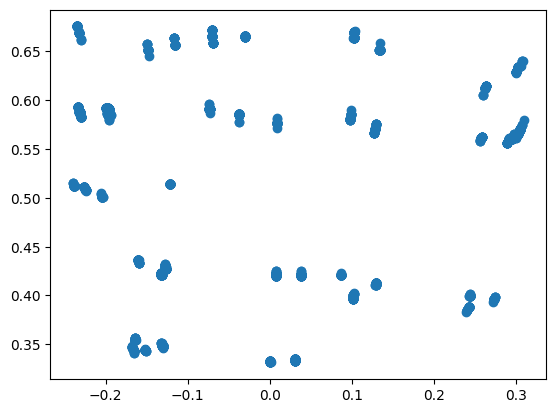

In [25]:
plt.scatter(ar_df['trigger']*ar_df['x'], ar_df['trigger']*ar_df['z'])

In [26]:
_rvecs = []

for i in range(len(ar_df['sync'])):
    if ar_df['sync'][i] == 1:
        _rvecs.append(ar_df[['rx','ry','rz']][i].to_numpy())
        
_rvecs = np.array(_rvecs).reshape(-1, 3)

In [27]:
np.linalg.norm(_rvecs.T[0])

21.653161786475682

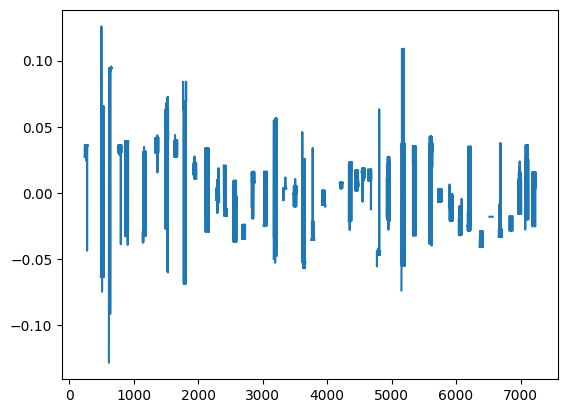

In [28]:
plt.plot(ar_df['trigger']*ar_df['ry'])

In [29]:
cv2.Rodrigues(ar_df[['rx', 'ry', 'rz']][0].to_numpy())[0]

array([[ 7.30865082e-01,  5.19745723e-04,  6.82521766e-01],
       [-5.21225145e-02, -9.97036944e-01,  5.65736265e-02],
       [ 6.80528820e-01, -7.69224388e-02, -7.28672398e-01]])